# Deep Learning a gyakorlatban Python és LUA alapon
## Ötödik kis házi feladat

Generatív modellezés

Készíts mély neuronháló alapú generatív modellt (pl. VAE, GAN, feltételes GAN), amely a CIFAR-10 adatbázis valamely kiválasztott kategóriájához (pl. béka) tartozó valósághű 32x32 pixeles képeket tud generálni!

Tetszőleges deep learning keretrendszert és github forráskódokat (megfelelően hivatkozva) használhatsz. A megoldást részletesen kommentezd és a tanítás kimenetét (log fájlját) is mellékeld. A leírás és kommentek angolul legyenek!

Beadási határidő: 2018. december 6. 23:59

Beadás: http://smartlab.tmit.bme.hu/oktatas-deep-learning#kishazi 

help : https://github.com/GANs-in-Action/gans-in-action/blob/master/chapter-3/Chapter_3_GAN.ipynb

még jobb: https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py

In [1]:
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
class DCGAN_image():
  
  # diszkriminátor: képről bináris döntése, 
  # hogy valódi vagy hamis
  
    def build_discriminator(self):
        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape = self.img_shape)

        validity = model(img)

        return Model(img, validity)
  
  # generátor hálózat: zajból kép generálás
    def build_generator(self):
        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((8, 8, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()
    
        noise = Input(shape = (self.latent_dim,))
        img = model(noise)

        return Model(noise, img)
  
    def __init__(self):
        self.img_rows = 32
        self.img_cols = 32
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 256

        optimizer = Adam(0.0002, 0.5)

        # diszkrimintár build és compile
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss = 'binary_crossentropy', 
                                  optimizer = optimizer,
                                  metrics = ['accuracy'])

        # generátor
        self.generator = self.build_generator()
        z = Input(shape = (self.latent_dim,))
        img = self.generator(z)

        # együttes modell - csak a generátort tanítjuk
        self.discriminator.trainable = False

        # diszkriminátor: generált képek valódiak?
        validity = self.discriminator(img)

        # együttes modell
        # cél: G megtanulja, hogyan csapja be D-t
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [4]:
from IPython import display

def plot_images(gan, epoch):
    r, c = 5, 2
    noise = np.random.normal(0, 1, ((r*c), gan.latent_dim))
    gen_imgs = gan.generator.predict(noise)

    # skálázás: -1 -- 1  -> 0 -- 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, ax = plt.subplots(r, c, figsize=(10,10))
    cnt = 0
    for i in range(r):
        for j in range(c):
            ax[i,j].imshow(gen_imgs[cnt, :, :, :])
            ax[i,j].axis('off')
            cnt += 1
            
    display.display(plt.gcf())

In [5]:
def show_imgs(X):
    plt.figure(1, figsize=(10,10))
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(X[k])
            plt.axis('off')
            k = k+1
    # show the plot
    plt.show()

In [6]:
# tanítási paraméterek
epochs = 1000
batch_size = 128
sample_interval = 50

In [7]:
gan = DCGAN_image()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 9, 9, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 9, 9, 64)          0         
__________

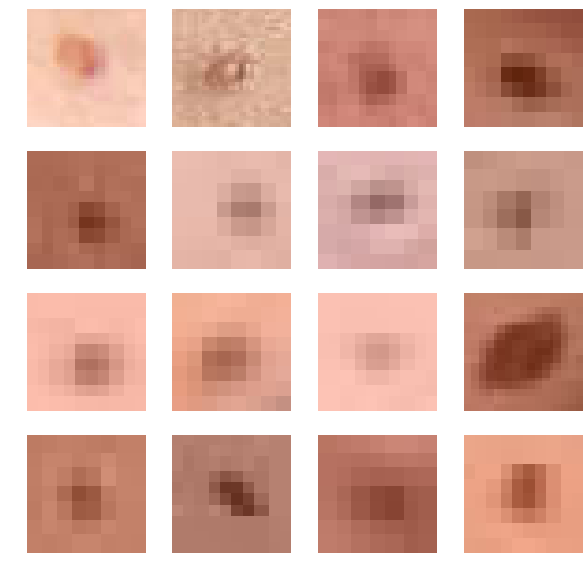

In [8]:
from PIL import Image
import glob

X_train = []

for file_path in glob.glob('Cropped/*.bmp'):
    X_train.append(np.asarray(Image.open(file_path)))
        
X_train = np.asarray(X_train)
show_imgs(X_train[:16])

In [9]:
# skálázás -1 és +1 közé
X_train = X_train / 127.5 - 1
# X_train = np.expand_dims(x_train, axis = 3)

# diszkriminátor kimenetek
valid = np.ones((batch_size, 1)) # D(x) = 1
fake = np.zeros((batch_size, 1)) # D(G(z)) = 0

d:\dl_bme\env\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 loss_D [1.3202372 0.4296875] loss_G 0.39881313


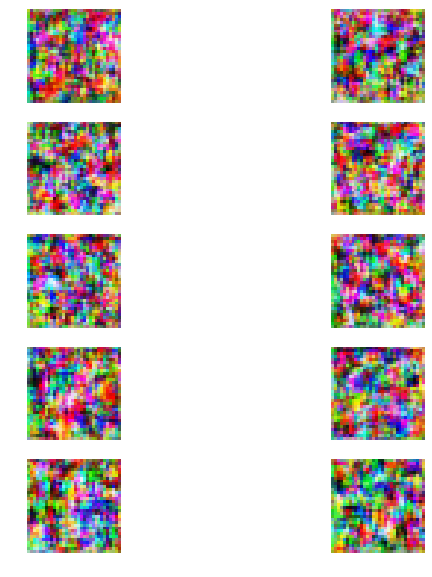

100 loss_D [0.10639372 0.98046875] loss_G 2.6081402


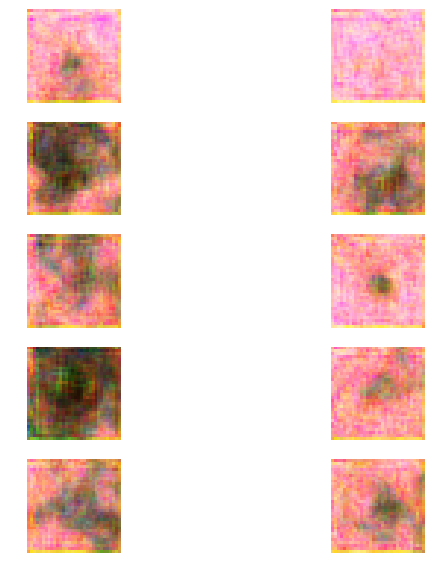

200 loss_D [0.8474034 0.484375 ] loss_G 1.738639


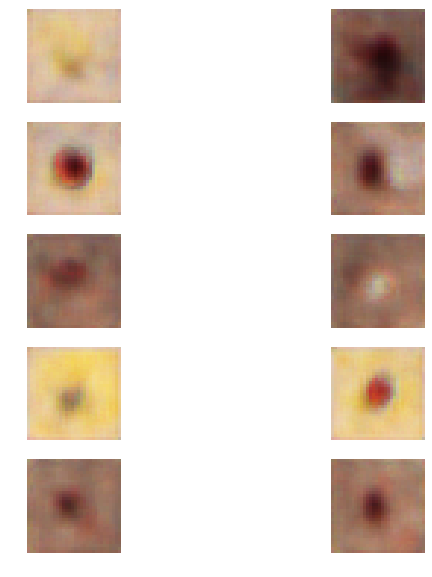

300 loss_D [0.8283861 0.484375 ] loss_G 1.3465714


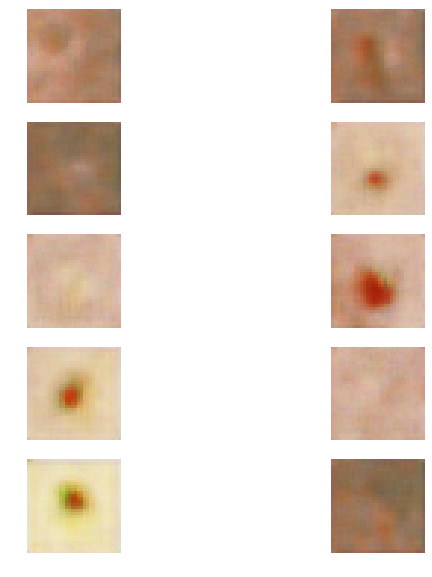

400 loss_D [0.32464552 0.86328125] loss_G 2.0404062


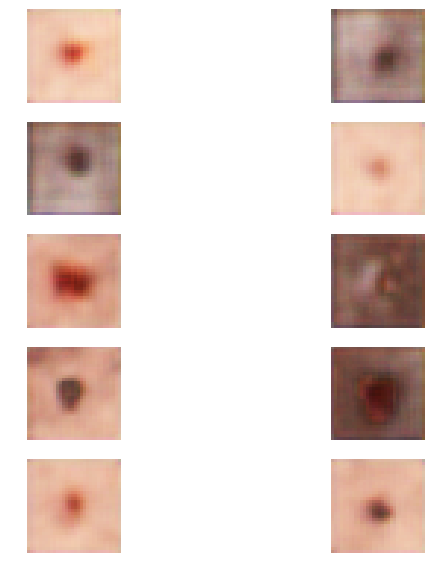

500 loss_D [0.21410513 0.94921875] loss_G 1.4326496


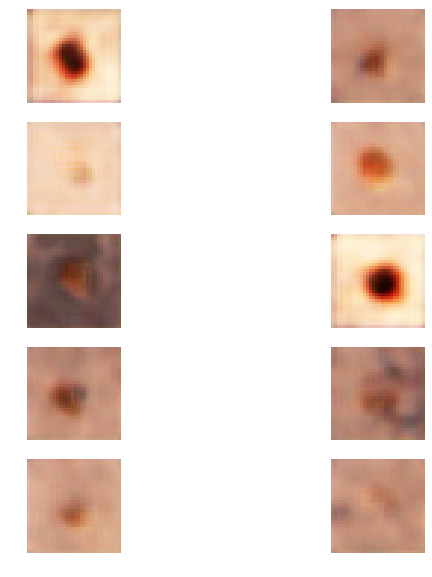

600 loss_D [0.24202026 0.9296875 ] loss_G 1.8183969


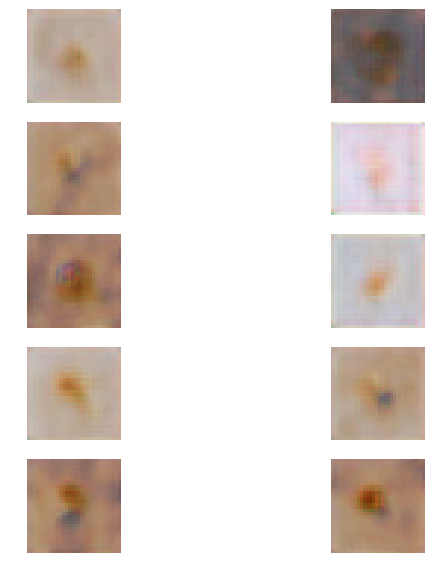

700 loss_D [0.404909   0.82421875] loss_G 2.2290285


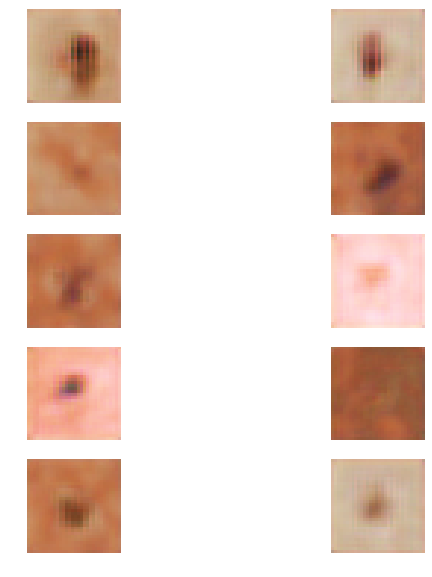

800 loss_D [0.6021793 0.6875   ] loss_G 3.2153542


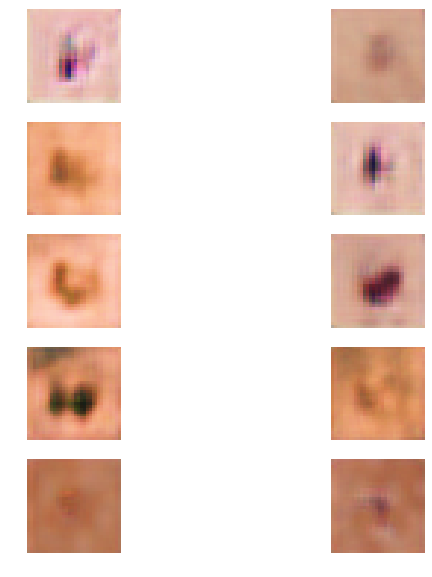

900 loss_D [0.4763792 0.78125  ] loss_G 1.374358


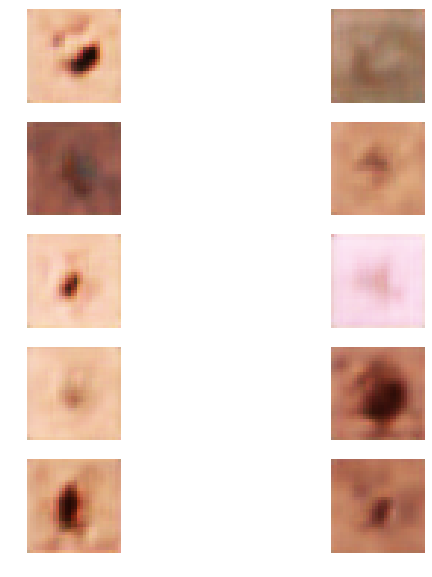

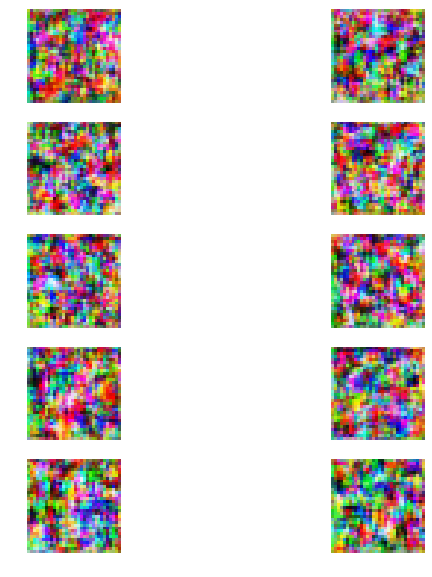

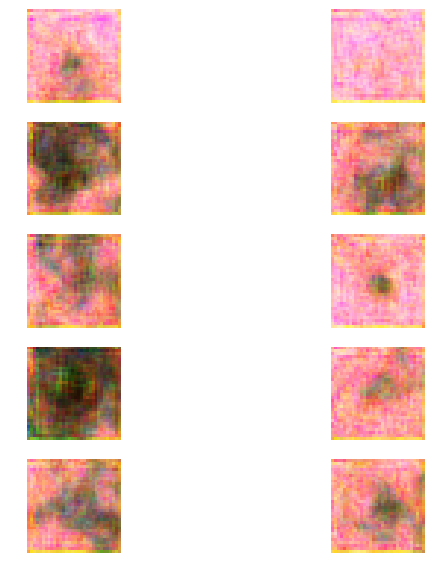

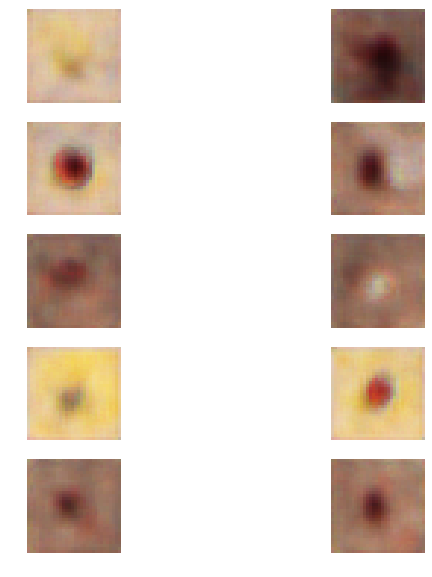

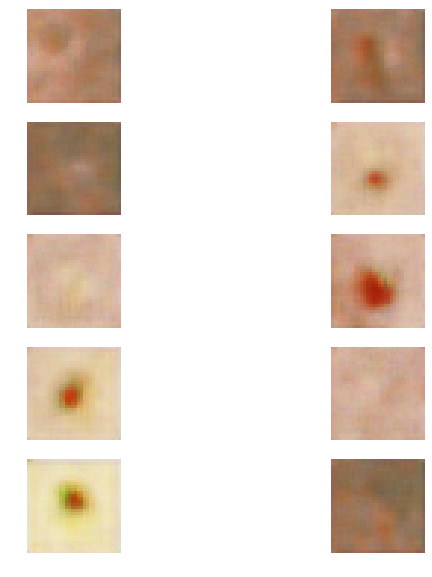

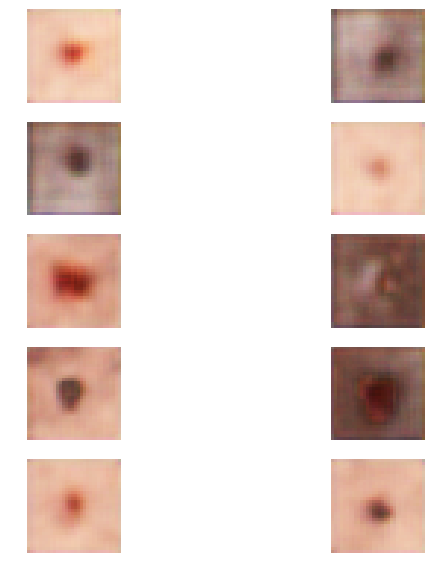

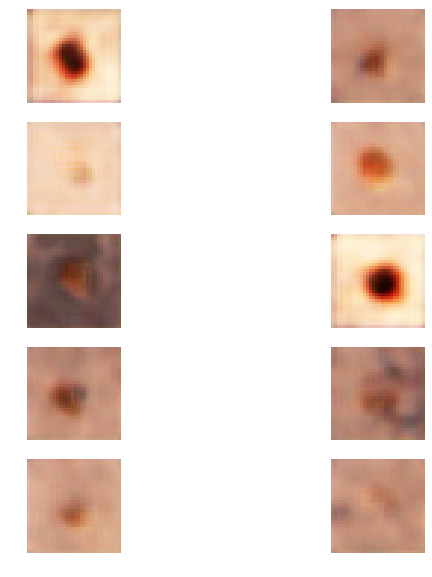

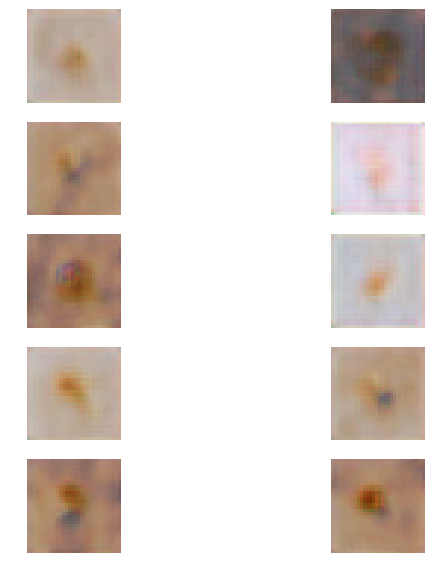

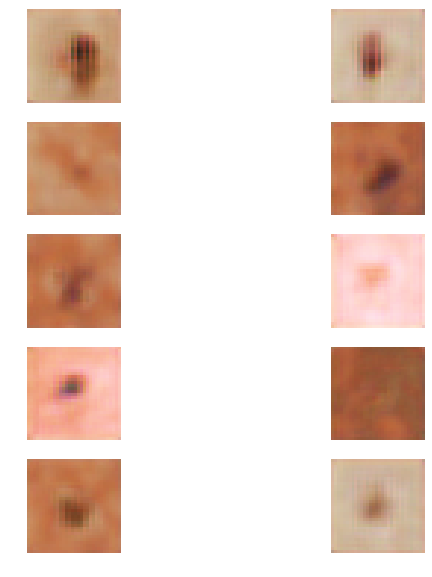

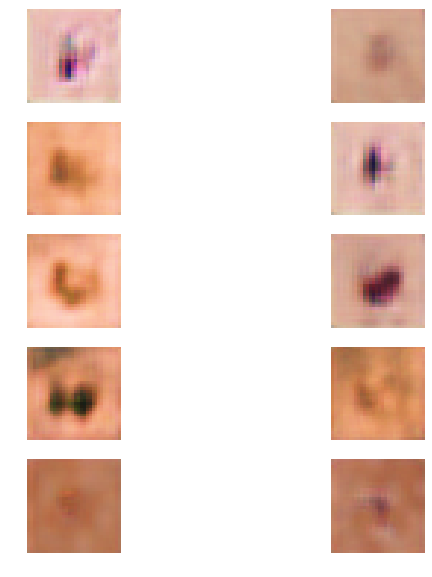

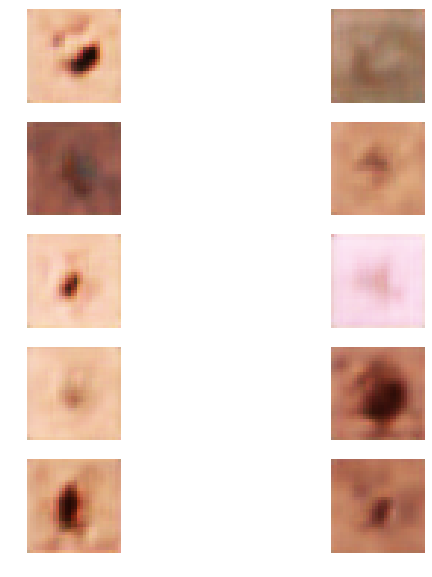

In [11]:
# G és D tanítása, kirajzolással

# Array initialization for logging of the losses
d_loss_real_logs = []
d_loss_fake_logs = []
g_loss_logs = []

for epoch in range(epochs):
  
    # képekből véletlen batch-nyi kiválasztása
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # egy batch-nyi kép generálás
    noise = np.random.normal(0, 1, (batch_size, gan.latent_dim))
    gen_imgs = gan.generator.predict(noise)

    # diszkriminátor tanítása
    d_loss_real = gan.discriminator.train_on_batch(imgs, valid)
    d_loss_fake = gan.discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # generátor tanítása
    g_loss = gan.combined.train_on_batch(noise, valid)

    # log és képek  
    if epoch % 100 == 0:
        print(epoch, 'loss_D', d_loss, 'loss_G', g_loss)
        plot_images(gan, epoch)
        
    # save log
    d_loss_real_logs.append([epoch, d_loss[0]])
    d_loss_fake_logs.append([epoch, d_loss[1]])
    g_loss_logs.append([epoch, g_loss])

* class-ba rendezni a függvényeket
* mentést megcsinálni
* lrate allithato

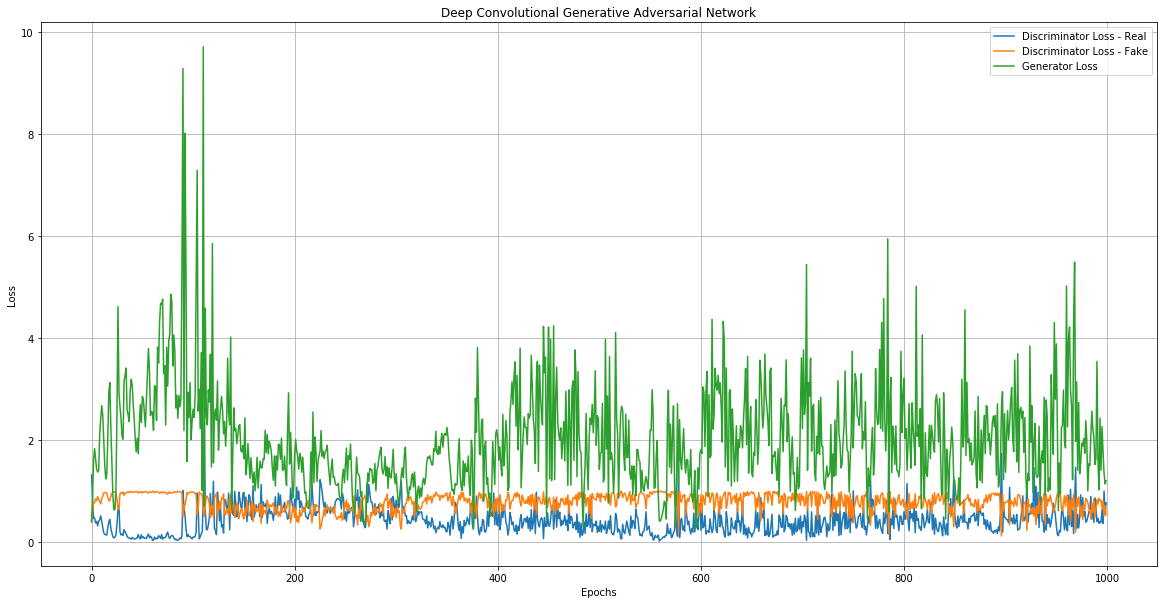

In [12]:
# https://github.com/miranthajayatilake/GANwKeras/blob/master/keras_gan.py
# plotting logs at the end
d_loss_real_logs = np.array(d_loss_real_logs)
d_loss_fake_logs = np.array(d_loss_fake_logs)
g_loss_logs = np.array(g_loss_logs)

# At the end of training plot the losses vs epochs
fig = plt.figure(figsize=(20,10))
plt.plot(d_loss_real_logs[:,0], d_loss_real_logs[:,1], label="Discriminator Loss - Real")
plt.plot(d_loss_fake_logs[:,0], d_loss_fake_logs[:,1], label="Discriminator Loss - Fake")
plt.plot(g_loss_logs[:,0], g_loss_logs[:,1], label="Generator Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Deep Convolutional Generative Adversarial Network')
plt.grid(True)
plt.show() 